In [1]:
import sys
import numpy as np
sys.path.append('../..')  # add the pde package to the python path
import pde
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField , plot_kymographs

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
rc('font',size=12)
rc('font',family='serif')
rc('axes',labelsize=12)


In [32]:
def coupled_KS_1D(parameters,sensing):
    upper_sensing = 0
    
    if sensing == 'rel':

        eq = PDE({"u": f"{parameters['u'][0]}*laplace(u) - {parameters['u'][1]}*get_x(gradient(u*gradient(c)/(c+{upper_sensing})))",
                  "v": f"{parameters['v'][0]}*laplace(v) - {parameters['v'][1]}*get_x(gradient(v*gradient(c)/(c+{upper_sensing})))",
                  "c": f"{parameters['c'][0]}*laplace(c) + {parameters['c'][1]} - {parameters['c'][2]}*c - {parameters['c'][3]}*u*(c)"}, bc="natural",
                 user_funcs={"get_x": lambda arr: arr[0]})
    elif sensing == 'abs':
        eq = PDE({"u": f"{parameters['u'][0]}*laplace(u) - {parameters['u'][1]}*get_x(gradient(u*gradient(c)))",
                  "v": f"{parameters['v'][0]}*laplace(v) - {parameters['v'][1]}*get_x(gradient(v*gradient(c)))",
                  "c": f"{parameters['c'][0]}*laplace(c) + {parameters['c'][1]} - {parameters['c'][2]}*c - {parameters['c'][3]}*u*(c)"}, bc="natural",
                 user_funcs={"get_x": lambda arr: arr[0]})
        
    return eq


In [56]:
def coupled_KS_1D_exp(parameters):
    upper_sensing = 0

    eq = PDE({"u": f"{parameters['u'][0]}*laplace(u) - {parameters['u'][1]}*get_x(gradient(u*gradient(c)/(c+{upper_sensing}))) + 0.001/(1 + exp((x - 5)))",
              "v": f"{parameters['v'][0]}*laplace(v) - {parameters['v'][1]}*get_x(gradient(v*gradient(c)/(c+{upper_sensing})))+  0.001/(1 + exp((x - 5)))",
              "c": f"{parameters['c'][0]}*laplace(c) + {parameters['c'][1]} - {parameters['c'][2]}*c - {parameters['c'][3]}*u*(c)"}, bc="natural",
             user_funcs={"get_x": lambda arr: arr[0]})

        
    return eq


In [3]:
def state_init(L,resol,offset,dens_DC,dens_T,dens_C):

    grid = CartesianGrid([[0, L]], [resol*L], periodic=False)

    initial_DC = ScalarField.random_uniform(grid,dens_DC,dens_DC+0.1)
    initial_DC.data[-resol*(L-offset):] = np.zeros(resol*(L-offset))

    initial_T = ScalarField.random_uniform(grid,dens_T,dens_T+0.1)
    initial_T.data[-resol*(L-offset):] = np.zeros(resol*(L-offset))
    
    initial_chem = ScalarField.random_uniform(grid,dens_C,dens_C+0.1)

    state = pde.FieldCollection([initial_DC, initial_T,initial_chem])
    
    return state

In [4]:
def solve_eq(eq,state,time,dt):
    # solve the equation and store the trajectory
    storage = MemoryStorage()
    eq.solve(state, t_range=time, tracker=storage.tracker(dt))
    
    return storage

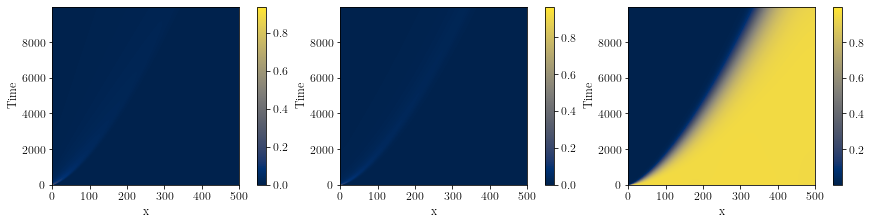

In [11]:
#%% Run exemplary simulation
parameters = dict()
parameters['u'] = [0.07,0.2]
parameters['v'] = [0.2,0.24]
parameters['c'] = [1,0,0,1]

# First check solutions without boundary influx:
eq_test = coupled_KS_1D(parameters,'rel')

L = 500
delta_x = 1

offset = 1
dens_DC = 0.9
dens_T = 0.9
dens_C = 0.9
state = state_init(L,delta_x,offset,dens_DC,dens_T,dens_C)

tmax = 10000

delta_t = 0.1

sol_test = solve_eq(eq_test,state,tmax,delta_t)

chi_set = [parameters['u'][1],parameters['v'][1]]
diff = [parameters['u'][0],parameters['v'][0]]

# plot the trajectory as a space-time plot
# First panel is Consumers, second panel is Sensors, third panel is Chemoattractant
plot_kymographs(sol_test,cmap='cividis');

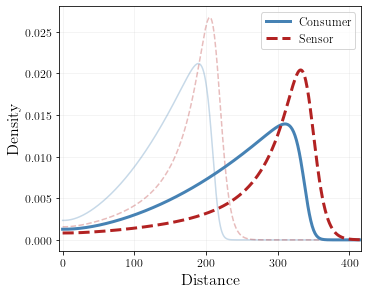

In [18]:
#%% Show sensing and generating cells in single plot over time
fig, axs = plt.subplots(figsize=(6,5))

t2 = int(tmax/delta_t)-1
t= int(t2/2)
x = np.arange(delta_x*L)/delta_x

axs.plot(x,sol_test[t][0].data,color='steelblue',alpha=0.3)  
axs.plot(x,sol_test[t][1].data,'--',color='firebrick',alpha=0.3)  

axs.plot(x,sol_test[t2][0].data,color='steelblue',alpha=1,lw=3,label=r'Consumer')  
axs.plot(x,sol_test[t2][1].data,'--',color='firebrick',alpha=1,lw=3,label=r'Sensor')  

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
axs.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.3)

axs.legend(fontsize=12,loc=1)

axs.set_xlim([-5, L/1.2])
#axs.set_ylim([0, 0.018])

#axs.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, labelleft=False)
# Axis labels
axs.set_xlabel(r'Distance',fontsize=16);
axs.set_ylabel(r'Density',fontsize=16);

# Add space at the bottom and left side of the exported pdf
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)


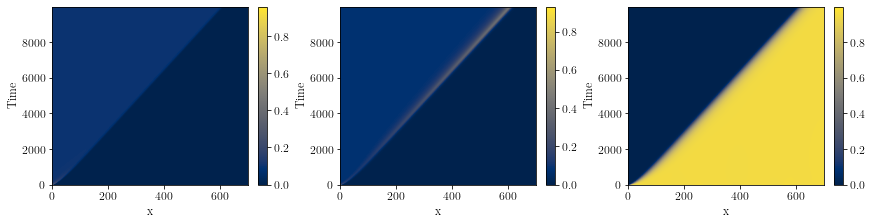

In [57]:
#%% Run exemplary simulation
parameters = dict()
parameters['u'] = [0.07,0.2]
parameters['v'] = [0.2,0.24]
parameters['c'] = [1,0,0,1]

# Solutions with localized source / influx of cells around x=0:
eq_test = coupled_KS_1D_exp(parameters)

L = 700
delta_x = 1

offset = 1
dens_DC = 0.9
dens_T = 0.9
dens_C = 0.9
state = state_init(L,delta_x,offset,dens_DC,dens_T,dens_C)

tmax = 10000

delta_t = 0.1

sol_test = solve_eq(eq_test,state,tmax,delta_t)

chi_set = [parameters['u'][1],parameters['v'][1]]
diff = [parameters['u'][0],parameters['v'][0]]

# plot the trajectory as a space-time plot
# First panel is Consumers, second panel is Sensors, third panel is Chemoattractant
plot_kymographs(sol_test,cmap='cividis');

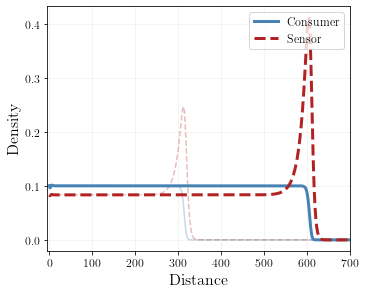

In [65]:
#%% Show sensing and generating cells in single plot over time
fig, axs = plt.subplots(figsize=(6,5))

t2 = int(tmax/delta_t)-1
t= int(t2/2)
x = np.arange(delta_x*L)/delta_x

axs.plot(x,sol_test[t][0].data,color='steelblue',alpha=0.3)  
axs.plot(x,sol_test[t][1].data,'--',color='firebrick',alpha=0.3)  

axs.plot(x,sol_test[t2][0].data,color='steelblue',alpha=1,lw=3,label=r'Consumer')  
axs.plot(x,sol_test[t2][1].data,'--',color='firebrick',alpha=1,lw=3,label=r'Sensor')  

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
axs.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.3)

axs.legend(fontsize=12,loc=1)

axs.set_xlim([-5, L])
#axs.set_ylim([0, 0.018])

#axs.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, labelleft=False)
# Axis labels
axs.set_xlabel(r'Distance',fontsize=16);
axs.set_ylabel(r'Density',fontsize=16);

# Add space at the bottom and left side of the exported pdf
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)


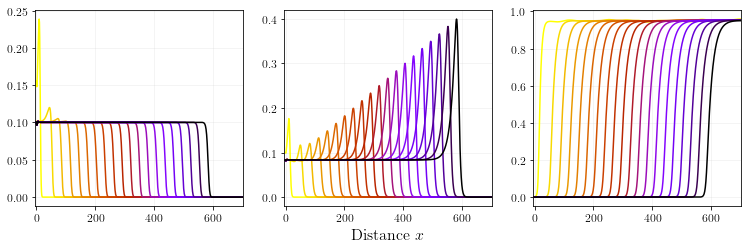

In [67]:
#%% Plot the profiles
x = np.arange(delta_x*L)/delta_x

times =  np.arange(tmax/delta_t)[int(10000*delta_t):][::int(500/delta_t)]

fig, axs = plt.subplots(1,3, figsize=(14,4))

# Reduce horizontal space between axes
fig.subplots_adjust(hspace=0.1)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(times))]

for j in np.arange(len(times)):
    
    axs[0].plot(x,sol_test[int(times[j])][0].data,color=colors[::-1][j])  
    axs[1].plot(x,sol_test[int(times[j])][1].data,color=colors[::-1][j])
    axs[2].plot(x,sol_test[int(times[j])][2].data,color=colors[::-1][j])

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
axs[0].grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.3)
axs[1].grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.3)
axs[2].grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.3)

axs[0].set_xlim([-5, L])
axs[1].set_xlim([-5, L])
axs[2].set_xlim([-5, L])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, labelleft=False)
plt.xlabel(r'Distance $x$',fontsize=16);
#plt.ylabel(r'Density',fontsize=16);

axs[0].tick_params(    
    which='both',labelsize=12) 
axs[1].tick_params(    
    which='both', labelsize=12) 
axs[2].tick_params(    
    which='both', labelsize=12) 

# Add space at the bottom and left side of the exported pdf
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
